### Import 

In [1]:
from skimage.io import imread
from skimage.transform import resize
import numpy as np
import math
import os
import glob
import pandas as pd
import cv2
import gc
import numpy as np
import random
import imageio
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

### Extract frames from video fucntion

In [2]:
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

def frames_from_video_file(video_path, n_frames, output_size = (224,224),frame_step=15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))  

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  frame_step = int(video_length//n_frames)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0,0)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result) #[..., [2, 1, 0]]

  return result

#def to_gif(images):
 # converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
 # imageio.mimsave('./animation.gif', converted_images, fps=10)
 # return embed.embed_file('./animation.gif')

### Get class names

In [3]:
class CFG:
    epochs = 10
    batch_size = 32
    classes = os.listdir("/kaggle/input/ucf21-new/UCF101_new")
    #classes = ["FloorGymnastics","PullUps"]

### Get video paths 

In [4]:
file_paths = []
targets = []
target_name = []
for i, cls in enumerate(CFG.classes):
    sub_file_paths = glob.glob(f"/kaggle/input/ucf21-new/UCF101_new/{cls}/**.avi")
    file_paths += sub_file_paths
    targets += [i] * len(sub_file_paths)
    target_name += [cls]

In [5]:
len(file_paths)

4249

In [6]:
len(targets)

4249

In [7]:
label_dict = dict()
for i, video_label in enumerate(target_name):
    label_dict[i] = video_label

### Split the paths dataset to train and test

In [13]:
train_paths, test_paths, train_targets, test_targets = train_test_split(file_paths, targets, test_size=0.0001, random_state=7)
len(train_paths), len(test_paths), len(train_targets), len(test_targets)

(4248, 1, 4248, 1)

### Split the train_paths dataset to train and val

In [14]:
train_paths, val_paths, train_targets, val_targets = train_test_split(train_paths, train_targets, test_size=0.05, random_state=7)
len(train_paths), len(val_paths), len(train_targets), len(val_targets)

(4035, 213, 4035, 213)

### Data loader

In [16]:
# using data loader to load images in batches
# `x_set` is list of path to the images
# `y_set` are the associated classes.

class train_DataLoader(tf.keras.utils.Sequence):

    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) *self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        #one hot encoding the labels data in our batch 
        frames_batch_x=[]
        for video_path in batch_x:
            frames_batch_x.append(frames_from_video_file(video_path, n_frames=15, output_size = (120,180)))
        frames_batch_x=np.array(frames_batch_x)
        cnn_features=[]
        for video in frames_batch_x:
            extracted_features = cnn_model.predict(video,verbose=0)
            cnn_features.append(extracted_features)
          
        
        return np.array(cnn_features), np.array(batch_y)


In [17]:
# using data loader to load images in batches
# `x_set` is list of path to the images
# `y_set` are the associated classes.

class val_DataLoader(tf.keras.utils.Sequence):

    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) *self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        #one hot encoding the labels data in our batch 
        frames_batch_x=[]
        for video_path in batch_x:
            frames_batch_x.append(frames_from_video_file(video_path, n_frames=15, output_size = (120,180)))
        frames_batch_x=np.array(frames_batch_x)
        cnn_features=[]
        for video in frames_batch_x:
            extracted_features = cnn_model.predict(video,verbose=0)
            cnn_features.append(extracted_features)
          
        
        return np.array(cnn_features), np.array(batch_y)


### CNN

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.vgg16 import preprocess_input
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout,GlobalAveragePooling2D

In [13]:
# Loading VGG16 model
base_model = VGG16(weights = "imagenet", include_top = False, input_shape = (120,180,3))

58889256/58889256 [==============================] - 0s 0us/step


In [14]:
#creating instance of our model and adding all vgg16 layers to it
cnn_model = Sequential()
for layer in base_model.layers:
    cnn_model.add(layer)
cnn_model.add(Flatten())
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 120, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 120, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 60, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 60, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 60, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 30, 45, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 30, 45, 256)       2

In [21]:
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SimpleRNN, GRU

In [22]:
len(CFG.classes)

21

# **Lstm model**

In [23]:
#create RNN model
lstm_model = Sequential()
#embedding for input words
#model.add(Embedding(input_dim = 10, output_dim = ,input_length = input_len))

#LSTM model
lstm_model.add(LSTM(128))
#output layer for num classes
lstm_model.add(Dense(len(CFG.classes),activation = "softmax"))

In [24]:
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model

In [25]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "model.h5", 
    monitor="val_accuracy",
    mode="max",
    save_best_only=True, 
    restore_best_weights=True
)


history = lstm_model.fit(
    train_DataLoader(train_paths,train_targets,batch_size=16),
    validation_data = val_DataLoader(val_paths,val_targets,batch_size=16),callbacks=[checkpoint],
    epochs=3)

Epoch 1/3
253/253 [==============================] - 809s 3s/step - loss: 1.9759 - accuracy: 0.4270 - val_loss: 1.4894 - val_accuracy: 0.5493
Epoch 2/3
253/253 [==============================] - 769s 3s/step - loss: 1.1866 - accuracy: 0.7061 - val_loss: 0.9165 - val_accuracy: 0.7746
Epoch 3/3
253/253 [==============================] - 782s 3s/step - loss: 0.7353 - accuracy: 0.8503 - val_loss: 0.6977 - val_accuracy: 0.8592


In [26]:
lstm_model.save("/kaggle/working/demo_uniform.h5")

In [33]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "model.h5", 
    monitor="val_accuracy",
    mode="max",
    save_best_only=True, 
    restore_best_weights=True
)


history = lstm_model.fit(
    train_DataLoader(train_paths,train_targets,batch_size=16),
    validation_data = val_DataLoader(val_paths,val_targets,batch_size=16),callbacks=[checkpoint],
    epochs=4)

Epoch 1/4
239/239 [==============================] - 874s 4s/step - loss: 1.6252 - accuracy: 0.5640 - val_loss: 1.0895 - val_accuracy: 0.7294
Epoch 2/4
239/239 [==============================] - 824s 3s/step - loss: 0.7510 - accuracy: 0.8514 - val_loss: 0.7054 - val_accuracy: 0.8282
Epoch 3/4
239/239 [==============================] - 837s 4s/step - loss: 0.4064 - accuracy: 0.9343 - val_loss: 0.4986 - val_accuracy: 0.8753
Epoch 4/4
239/239 [==============================] - 835s 3s/step - loss: 0.2212 - accuracy: 0.9746 - val_loss: 0.4044 - val_accuracy: 0.8988


In [34]:
# serialize model to JSON
model_json = lstm_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
lstm_model.save_weights("model.h5")

In [4]:
from keras.models import model_from_json

# load json and create model
json_file = open('/kaggle/input/tryjson1/uniform_sampling_jsonfile.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model


In [6]:
loaded_model.load_weights("/kaggle/input/edgedetectionmodel-1/edge_detection_model.h5")

ValueError: Cannot assign value to variable ' lstm/lstm_cell_1/kernel:0': Shape mismatch.The variable shape (7160, 512), and the assigned value shape (7680, 512) are incompatible.

In [1]:
from keras.models import model_from_json

# load json and create model
json_file = open('/kaggle/input/jsonmodel/model.json', 'r')
loaded_model_json = json_file.read()

In [6]:
loaded_model_json

'"'

In [7]:
import json

with open('/kaggle/input/jsonmodel/model.json', 'r+') as f:
    data = json.load(f)

OSError: [Errno 30] Read-only file system: '/kaggle/input/jsonmodel/model.json'

In [36]:
lstm_model.save("/kaggle/working/uniform1.h5")

In [52]:
lstm_model.load_weights("model.h5")

In [3]:
model = tf.keras.models.load_model("/kaggle/input/testmodelupload/transformer_conv2D_final.h5")

In [27]:
import h5py

with h5py.File('/kaggle/input/uniformsampling1/uniform_samping_1.h5', 'r') as file:
    print(list(file.keys()))

['model_weights', 'optimizer_weights']


In [62]:
import tensorflow as tf

class MyModel(tf.keras.Model):
    def __init__(self, num_classes):
        super(MyModel, self).__init__()
        
        # Define the layers
        self.lstm_layer = tf.keras.layers.LSTM(128)
        self.output_layer = tf.keras.layers.Dense(num_classes, activation='softmax')
        
    def call(self, inputs):
        # Define the forward pass
        x = self.lstm_layer(inputs)
        x = self.output_layer(x)
        return x

In [63]:
model=MyModel(21)

In [46]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [40]:
model

In [50]:
from keras.models import load_model
model=load_model(r"/kaggle/input/uniformsampling1/uniform_samping_1.h5")

TypeError: int() argument must be a string, a bytes-like object or a number, not 'NoneType'

In [47]:
model.load_weights('/kaggle/input/uniformsampling1/uniform_samping_1.h5')

ValueError: Unable to load weights saved in HDF5 format into a subclassed Model which has not created its variables yet. Call the Model first, then load the weights.

In [14]:
model_1 = tf.keras.models.load_model(r"/kaggle/input/testmodelupload/transformer_conv2D_final.h5")

In [8]:
model = tf.keras.models.load_model("/kaggle/input/final-model/final_model.h5")

In [58]:
model = tf.keras.models.load_model("/kaggle/input/final-demo/model_effnet_lstm_att.h5")

In [53]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "model.h5", 
    monitor="val_accuracy",
    mode="max",
    save_best_only=True, 
    restore_best_weights=True
)


history = lstm_model.fit(
    train_DataLoader(train_paths,train_targets,batch_size=16),
    validation_data = val_DataLoader(val_paths,val_targets,batch_size=16),callbacks=[checkpoint],
    epochs=5)

Epoch 1/5

211/211 [==============================] - 921s 4s/step - loss: 1.6713 - accuracy: 0.5413 - val_loss: 1.2303 - val_accuracy: 0.7114

Epoch 2/5

211/211 [==============================] - 892s 4s/step - loss: 0.8535 - accuracy: 0.8237 - val_loss: 0.8455 - val_accuracy: 0.7886

Epoch 3/5

211/211 [==============================] - 890s 4s/step - loss: 0.5061 - accuracy: 0.9114 - val_loss: 0.5936 - val_accuracy: 0.8575

Epoch 4/5

211/211 [==============================] - 891s 4s/step - loss: 0.2939 - accuracy: 0.9590 - val_loss: 0.4343 - val_accuracy: 0.9074

Epoch 5/5

211/211 [==============================] - 900s 4s/step - loss: 0.1665 - accuracy: 0.9807 - val_loss: 0.3460 - val_accuracy: 0.9240


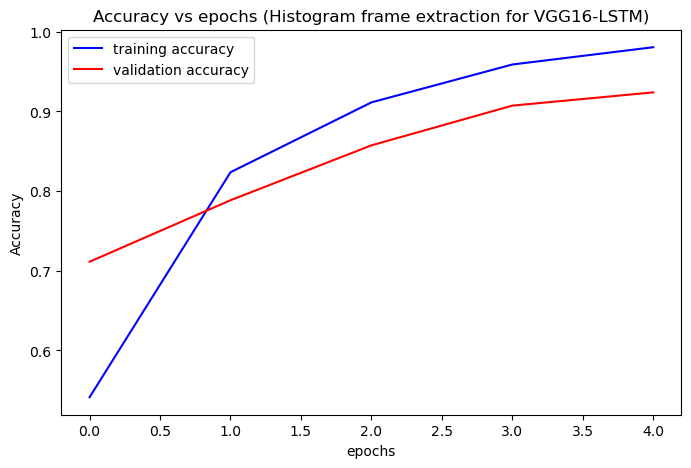

In [54]:
#accuracy plot
plt.figure(figsize = (8,5))
x = np.arange(0,5,1)
plt.plot(x,history.history["accuracy"],label = "training accuracy",c = 'blue')
plt.plot(x,history.history["val_accuracy"],label = "validation accuracy",c = 'red')
plt.legend()
plt.title("Accuracy vs epochs (Histogram frame extraction for VGG16-LSTM)")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.show()

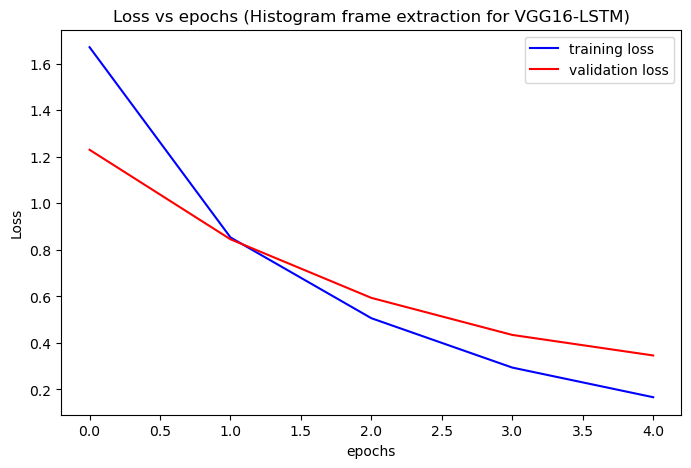

In [55]:
#accuracy plot
plt.figure(figsize = (8,5))
x = np.arange(0,5,1)
plt.plot(x,history.history["loss"],label = "training loss",c = 'blue')
plt.plot(x,history.history["val_loss"],label = "validation loss",c = 'red')
plt.legend()
plt.title("Loss vs epochs (Histogram frame extraction for VGG16-LSTM)")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.show()

# Prediction

In [75]:
test_videos_path = test_paths
num = np.random.randint(0,len(test_videos_path),1)
test_file_path = test_videos_path[num[0]]
test_file_path

'/kaggle/input/ucf21-new/UCF101_new/ApplyingMakeup/v_ApplyEyeMakeup_g12_c04.avi'

In [76]:
features = []
features.append(frames_from_video_file(test_file_path, n_frames = 10))
features = np.array(features)


In [77]:
cnn_features_test = []
for video in features :
        #img = image.load_img(img_path,target_size = (32,32))
        #x = image.img_to_array(img)
        #x = np.expand_dims(frame,axis=0)
        #x = preprocess_input(x)
    extracted_features = cnn_model.predict(video)
    cnn_features_test.append(extracted_features)

1/1 [==============================] - 0s 20ms/step


In [78]:
predicted_class = lstm_model.predict(np.array(cnn_features_test))

1/1 [==============================] - 0s 21ms/step


In [79]:
# Getting indices of N = 3 maximum values
index = np.argsort(predicted_class[0])[::-1][:3]
#print("Indices:",index)

# Getting N maximum values
percentage_class = predicted_class[0][index]
#print("Values:",percentage_class)

num = -1
for i in index:
    num+=1
    a = label_dict[i]
    b = percentage_class[num]*100
    print(f"{a} : {b:.3f} percent")

ApplyingMakeup : 99.468 percent

PlayingMusicalInstrument : 0.216 percent

SumoWrestling : 0.082 percent


### Test

In [37]:
features = []
features.append(frames_from_video_file("/kaggle/input/test-videos/test/test10.mp4", n_frames = 20))
features = np.array(features)

In [10]:
for video in os.listdir("/kaggle/input/test-videos/test"):
    print(video)
    features = []
    features.append(frames_from_video_file("/kaggle/input/test-videos/test/"+video, n_frames = 25))
    features = np.array(features)
    predicted_class = model.predict(np.array(features))
    # Getting indices of N = 3 maximum values
    index = np.argsort(predicted_class[0])[::-1][:5]
#print("Indices:",index)

# Getting N maximum values
    percentage_class = predicted_class[0][index]
#print("Values:",percentage_class)

    num = -1
    for i in index:
        num+=1
        a = label_dict[i]
        b = percentage_class[num]*100
        print(f"{a} : {b:.3f} percent")
    

test10.mp4
1/1 [==============================] - 18s 18s/step
JavelinThrow : 18.359 percent
SkyDiving : 17.072 percent
PullUps : 11.544 percent
FieldHockeyPenalty : 6.717 percent
IceDancing : 5.610 percent
test4.mp4
1/1 [==============================] - 0s 143ms/step
JavelinThrow : 16.056 percent
SkyDiving : 15.766 percent
PullUps : 10.174 percent
FieldHockeyPenalty : 7.016 percent
IceDancing : 6.260 percent
test5.mp4
1/1 [==============================] - 0s 139ms/step
JavelinThrow : 16.712 percent
SkyDiving : 15.727 percent
PullUps : 12.744 percent
FieldHockeyPenalty : 6.921 percent
IceDancing : 6.110 percent
test3.mp4
1/1 [==============================] - 0s 141ms/step
JavelinThrow : 25.388 percent
SkyDiving : 14.039 percent
PullUps : 8.033 percent
PlayingBasketball : 7.515 percent
PlayingMusicalInstrument : 7.200 percent
test8.mp4
1/1 [==============================] - 0s 138ms/step
SkyDiving : 18.513 percent
JavelinThrow : 15.133 percent
PullUps : 13.528 percent
IceDancing : 6.

In [38]:
predicted_class = model.predict(np.array(features))

1/1 [==============================] - 0s 46ms/step


In [39]:
# Getting indices of N = 3 maximum values
index = np.argsort(predicted_class[0])[::-1][:5]
#print("Indices:",index)

# Getting N maximum values
percentage_class = predicted_class[0][index]
#print("Values:",percentage_class)

num = -1
for i in index:
    num+=1
    a = label_dict[i]
    b = percentage_class[num]*100
    print(f"{a} : {b:.3f} percent")

PullUps : 98.548 percent
FloorGymnastics : 0.570 percent
PushUps : 0.242 percent
LongJump : 0.231 percent
SkateBoarding : 0.106 percent


### Test videos